# Evaluations of different model over the prerpocessed data

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, TheilSenRegressor, Lasso
from sklearn.naive_bayes import GaussianNB
import sklearn.decomposition as decomposition
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
import os
import seaborn as sns
import pandas as pd
from custom_print import *
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingRegressor, AdaBoostRegressor,RandomForestRegressor, HistGradientBoostingRegressor

SEED = 42

In [17]:
import datetime

class colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    ORANGE = '\033[33m'
    RESULT =  '\033[94m'
    WARNING = '\033[93m'
    DEBUGGING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def now():
    return datetime.datetime.now().strftime("%H:%M:%S")

def print_error(*args, **kwargs):
    print(now()+" ["+colors.BOLD+colors.FAIL+"ERROR"+colors.ENDC+"] " +" ".join(map(str,args))+"\n", **kwargs)
    
def print_warning(*args, **kwargs):
    print(now()+" ["+colors.BOLD+colors.ORANGE+"WARNING"+colors.ENDC+"] " +" ".join(map(str,args))+ "\n", **kwargs)

def print_debugging(*args, **kwargs):
    print(now()+" ["+colors.BOLD+colors.DEBUGGING+"DEBUG"+colors.ENDC+"] " +" ".join(map(str,args))+"\n", **kwargs)
    
def print_info(*args, **kwargs):
    print(now()+" ["+colors.BOLD+colors.OKGREEN+"INFO"+colors.ENDC+"] "+" ".join(map(str,args))+"\n", **kwargs)

def print_configs(*args, **kwargs):
    print(now()+" ["+colors.BOLD+colors.OKBLUE+"CONFIGS"+colors.ENDC+"] "+" ".join(map(str,args))+"\n", **kwargs)

## Models tested:

In [18]:
def hist_gb_regression(x,y):
    print_configs("Model: Hist Gradient Boosting")
    model = HistGradientBoostingRegressor(random_state=SEED).fit(x, y)
    return model

def lasso_regression(x,y):
    print_configs("Model: Lasso Regression")
    model = Lasso(alpha=0.1).fit(x, y)
    return model

def adaboost_regression(x,y):
    print_configs("Model: AdaBoost")
    model = AdaBoostRegressor(random_state=SEED, n_estimators=100).fit(x, y)
    return model

def stack_regression(x,y):
    estimators = [('gbr', HistGradientBoostingRegressor(random_state=SEED)), ('lasso', Lasso(alpha=0.1)),
                  ('adaboost', AdaBoostRegressor(random_state=SEED, n_estimators=100)), ('gb', GradientBoostingRegressor( random_state=SEED)),
                  ('lin', LinearRegression()), ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.2))]
    model = StackingRegressor(estimators=estimators, final_estimator= RandomForestRegressor(n_estimators=1000,random_state=SEED)).fit(x, y)
    return model

def svr_regression(x,y):
    # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
    print_configs("Model: SVR")
    model = SVR(kernel='rbf', C=1.0, epsilon=0.2).fit(x, y)
    return model
    
def lin_regr(x, y):
    print_configs("Model: Linear Regression")
    model = LinearRegression().fit(x, y)
    return model

def grad_boost(x, y):
    print_configs("Model: Gradient Boosting")
    # 'poisson', 'quantile'
    model = GradientBoostingRegressor(random_state=SEED).fit(x, y)
    return model

def perceptron(x, y):
    print_debugging("Model: Perceptron")
    model = Perceptron(tol=1e-3, random_state=SEED).fit(x, y)
    return model

def ml_nn(x, y):
    print_configs("Model: Multi Layer Perceptron")
    model = MLPRegressor(random_state=1, max_iter=2000, activation='tanh', solver='lbfgs').fit(x, y)
    return model

## Evaluator Class:

In [19]:
class Model_Evaluator():
    def __init__(self) -> None:
        pass
    
    def remove_outliers(self, df):
        df = df.drop(columns=['y-m-day-hour_6_rounded'])
        clf = IsolationForest(random_state=SEED).fit(df)
        y_pred = clf.predict(df)
        df['outlier'] = y_pred
        
        clr = ['r' if item == -1 else 'g' for item in y_pred]
        # plt.scatter(df['cumulative_per_day_n_barcode'], df['work_time'], c=clr)
        # plt.show()
        df = df[df['outlier'] == 1]
        df = df.drop(columns=['outlier'])
        return df

    def scale(self, x,y):
        scaler_x = preprocessing.RobustScaler()
        scaler_y = preprocessing.RobustScaler()
        x = scaler_x.fit_transform(x)
        y = y.ravel()
        return x, y, scaler_y

    def evaluations(self, x,y, f, desc = None):
        
        if desc is not None:
            print_info(desc)
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        skf = StratifiedKFold(n_splits=10)
        model = f(X_train, y_train)
        train_score = model.score(X_train, y_train)
        print_info(f"Model score: {train_score}")
        test_score = model.score(X_test, y_test)
        model_prediction = model.predict(X_test)
        mse = mean_squared_error(y_test, model_prediction)
        r2 = r2_score(y_test, model_prediction)
        print_info("Metrics are:\n Accuracy: {}\n MSE: {} \n R2: {}\n\n".format(test_score, mse, r2))
        
        # print_info("Predictions:")
        # for i in range(len(y_test)//20):
        #     print("y_test[{}]: {}, model_prediction[{}]: {}".format(i, y_test[i], i, model_prediction[i]))
        data_used = (X_train, X_test, y_train, y_test)
        
        return model, data_used

    def get_data(self, mach_index):
        file_dir = '../Data/data_per_machine/2022/processed_with_cumulatives/'
        file_list = os.listdir(file_dir)
        mach_name = [file.replace('.csv','') for file in file_list]
        file = file_dir + file_list[mach_index]
        df = pd.read_csv(file)
        current_machine = mach_name[mach_index]
        return df, current_machine

    def split_tot_L_R_df(self, df):
        list_col = df.columns.to_list()
        list_tot_col = []
        list_L_col = []
        list_R_col = []
        for col in list_col:
            if '_L' in col:
                list_L_col.append(col)
            elif '_R' in col:
                list_R_col.append(col)
            else:
                list_tot_col.append(col)
        df_tot = df[list_tot_col]
        df_L = df[list_L_col]
        df_R = df[list_R_col]
        return df_tot, df_L, df_R
    
    def get_x_y(self, df):
        cols = df.columns.to_list()
        for col in cols:
            if 'cumulative_per_day_CYCLE_ABORTED' in col:
                y = df[col].to_numpy()
        cols_to_drop = ['y-m-day-hour_6_rounded', 'cumulative_per_day_n_barcode',
        'cumulative_per_day_n_barcode_L', 'cumulative_per_day_n_barcode_R',
        'CYCLE_NOT_STARTED', 'CYCLE_NOT_STARTED_L', 'CYCLE_NOT_STARTED_R',
        'cumulative_per_day_CYCLE_COMPLETED',
        'cumulative_per_day_CYCLE_ABORTED',
        'cumulative_per_day_CYCLE_NOT_STARTED',
        'cumulative_per_day_CYCLE_COMPLETED_L',
        'cumulative_per_day_CYCLE_ABORTED_L',
        'cumulative_per_day_CYCLE_NOT_STARTED_L',
        'cumulative_per_day_CYCLE_COMPLETED_R',
        'cumulative_per_day_CYCLE_ABORTED_R',
        'cumulative_per_day_CYCLE_NOT_STARTED_R']
        _cols_to_drop = []
        for col in cols_to_drop:
            if col in cols:
                _cols_to_drop.append(col)
        
        df = df.drop(columns=_cols_to_drop)
        x_cols = df.columns.to_list()
        x = df.to_numpy()
        return x, y, x_cols

    def explain_model(self, model, train, test, x_cols, scale_y = None):
        import lime
        from lime import lime_tabular
        import random
        explainer = lime_tabular.LimeTabularExplainer(train, feature_names=x_cols, class_names=['cumulative_per_day_CYCLE_ABORTED'], verbose=True, mode='regression')
        figure, ax = plt.subplots(2,2)
        figure.set_size_inches(40,20)
        plt.subplots_adjust(left=0.17,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.4)
        # plt.subplot_tool()
        for i in  range(4):
            var = random.randint(0, len(test)-1)
            exp = explainer.explain_instance(test[var], model.predict, num_features=3)
            explanation_list = exp.as_list()
            clr = ['r' if item[1] < 0 else 'g' for item in explanation_list]
            ax[i//2][i%2].barh([item[0] for item in explanation_list], [item[1] for item in explanation_list], color=clr)
            ax[i//2][i%2].set_title(f'Prediction: {model.predict(test[var].reshape(1,-1))}, Actual: {scale_y[var]}')
            ax[i//2][i%2].set_xlabel('feature importance')
            ax[i//2][i%2].set_ylabel('Features')
            ax[i//2][i%2].set_xlim(-3,3)
            ax[i//2][i%2].set_ylim(-1,3)
            ax[i//2][i%2].set_yticks([item[0] for item in explanation_list])
            ax[i//2][i%2].set_yticklabels([item[0] for item in explanation_list])
            ax[i//2][i%2].set_xticks([i for i in range(-3,3)])
            ax[i//2][i%2].invert_yaxis()
            ax[i//2][i%2].grid()
        plt.show()

## Train-Test and evaluation of the models

13:33:05 [INFO] SVR

13:33:05 [CONFIGS] Model: SVR

13:33:07 [INFO] Model score: 0.5361477259510794

13:33:08 [INFO] Metrics are:
 Accuracy: 0.534479118215877
 MSE: 40.603946106835465 
 R2: 0.534479118215877



13:33:08 [INFO] Linear Regression

13:33:08 [CONFIGS] Model: Linear Regression

13:33:08 [INFO] Model score: 0.5524462124941076

13:33:08 [INFO] Metrics are:
 Accuracy: 0.5475321540832162
 MSE: 39.46542625600349 
 R2: 0.5475321540832162



13:33:08 [INFO] Gradient Boosting

13:33:08 [CONFIGS] Model: Gradient Boosting

13:33:08 [INFO] Model score: 0.5969357638817816

13:33:08 [INFO] Metrics are:
 Accuracy: 0.5654350848188879
 MSE: 37.90388591873732 
 R2: 0.5654350848188879



13:33:08 [INFO] Stacking

13:33:48 [INFO] Model score: 0.6373525958396982

13:33:49 [INFO] Metrics are:
 Accuracy: 0.5532732276334129
 MSE: 38.96467483936636 
 R2: 0.5532732276334129



13:33:49 [INFO] AdaBoost

13:33:49 [CONFIGS] Model: AdaBoost

13:33:49 [INFO] Model score: 0.5138955568866228

13:33:49 [IN

/tmp/ipykernel_10400/56163111.py:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(3,1,1)
/tmp/ipykernel_10400/56163111.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(3,1,2)
/tmp/ipykernel_10400/56163111.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(3,1,3)


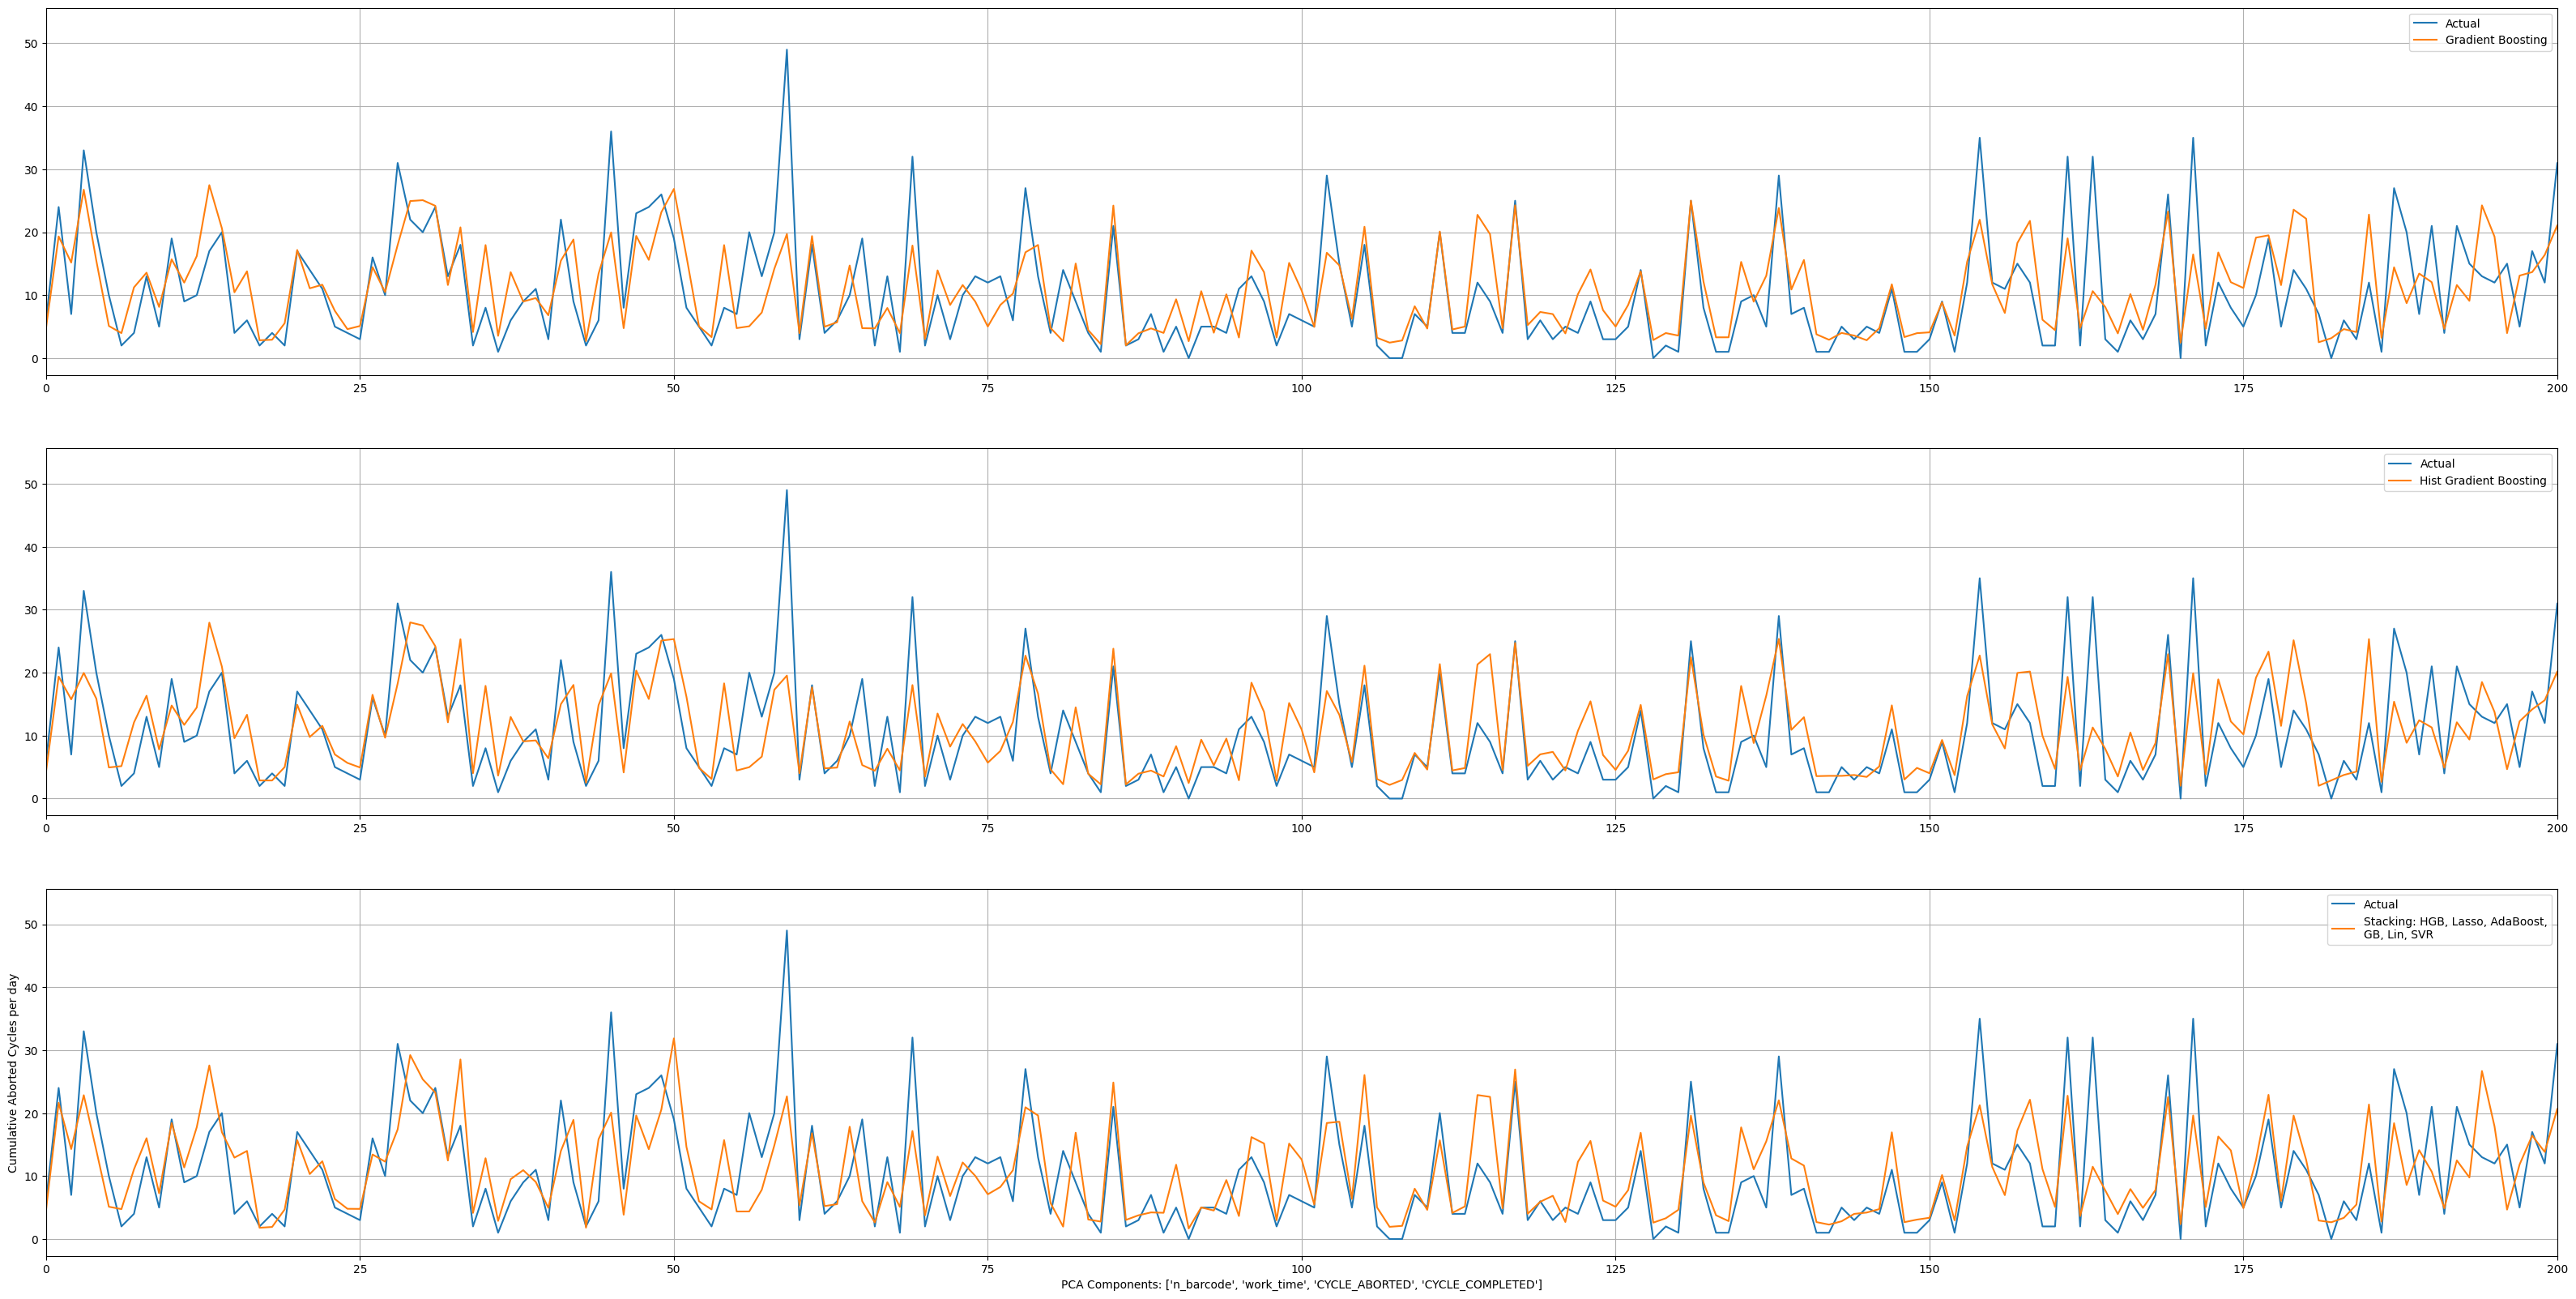

Intercept 11.442217625814447
Prediction_local [16.66766459]
Right: 24.375
Intercept 14.32944352709897
Prediction_local [9.28448851]
Right: 1.917
Intercept 13.980405960293126
Prediction_local [10.89051934]
Right: 5.201
Intercept 14.365669620200915
Prediction_local [10.4411655]
Right: 5.067


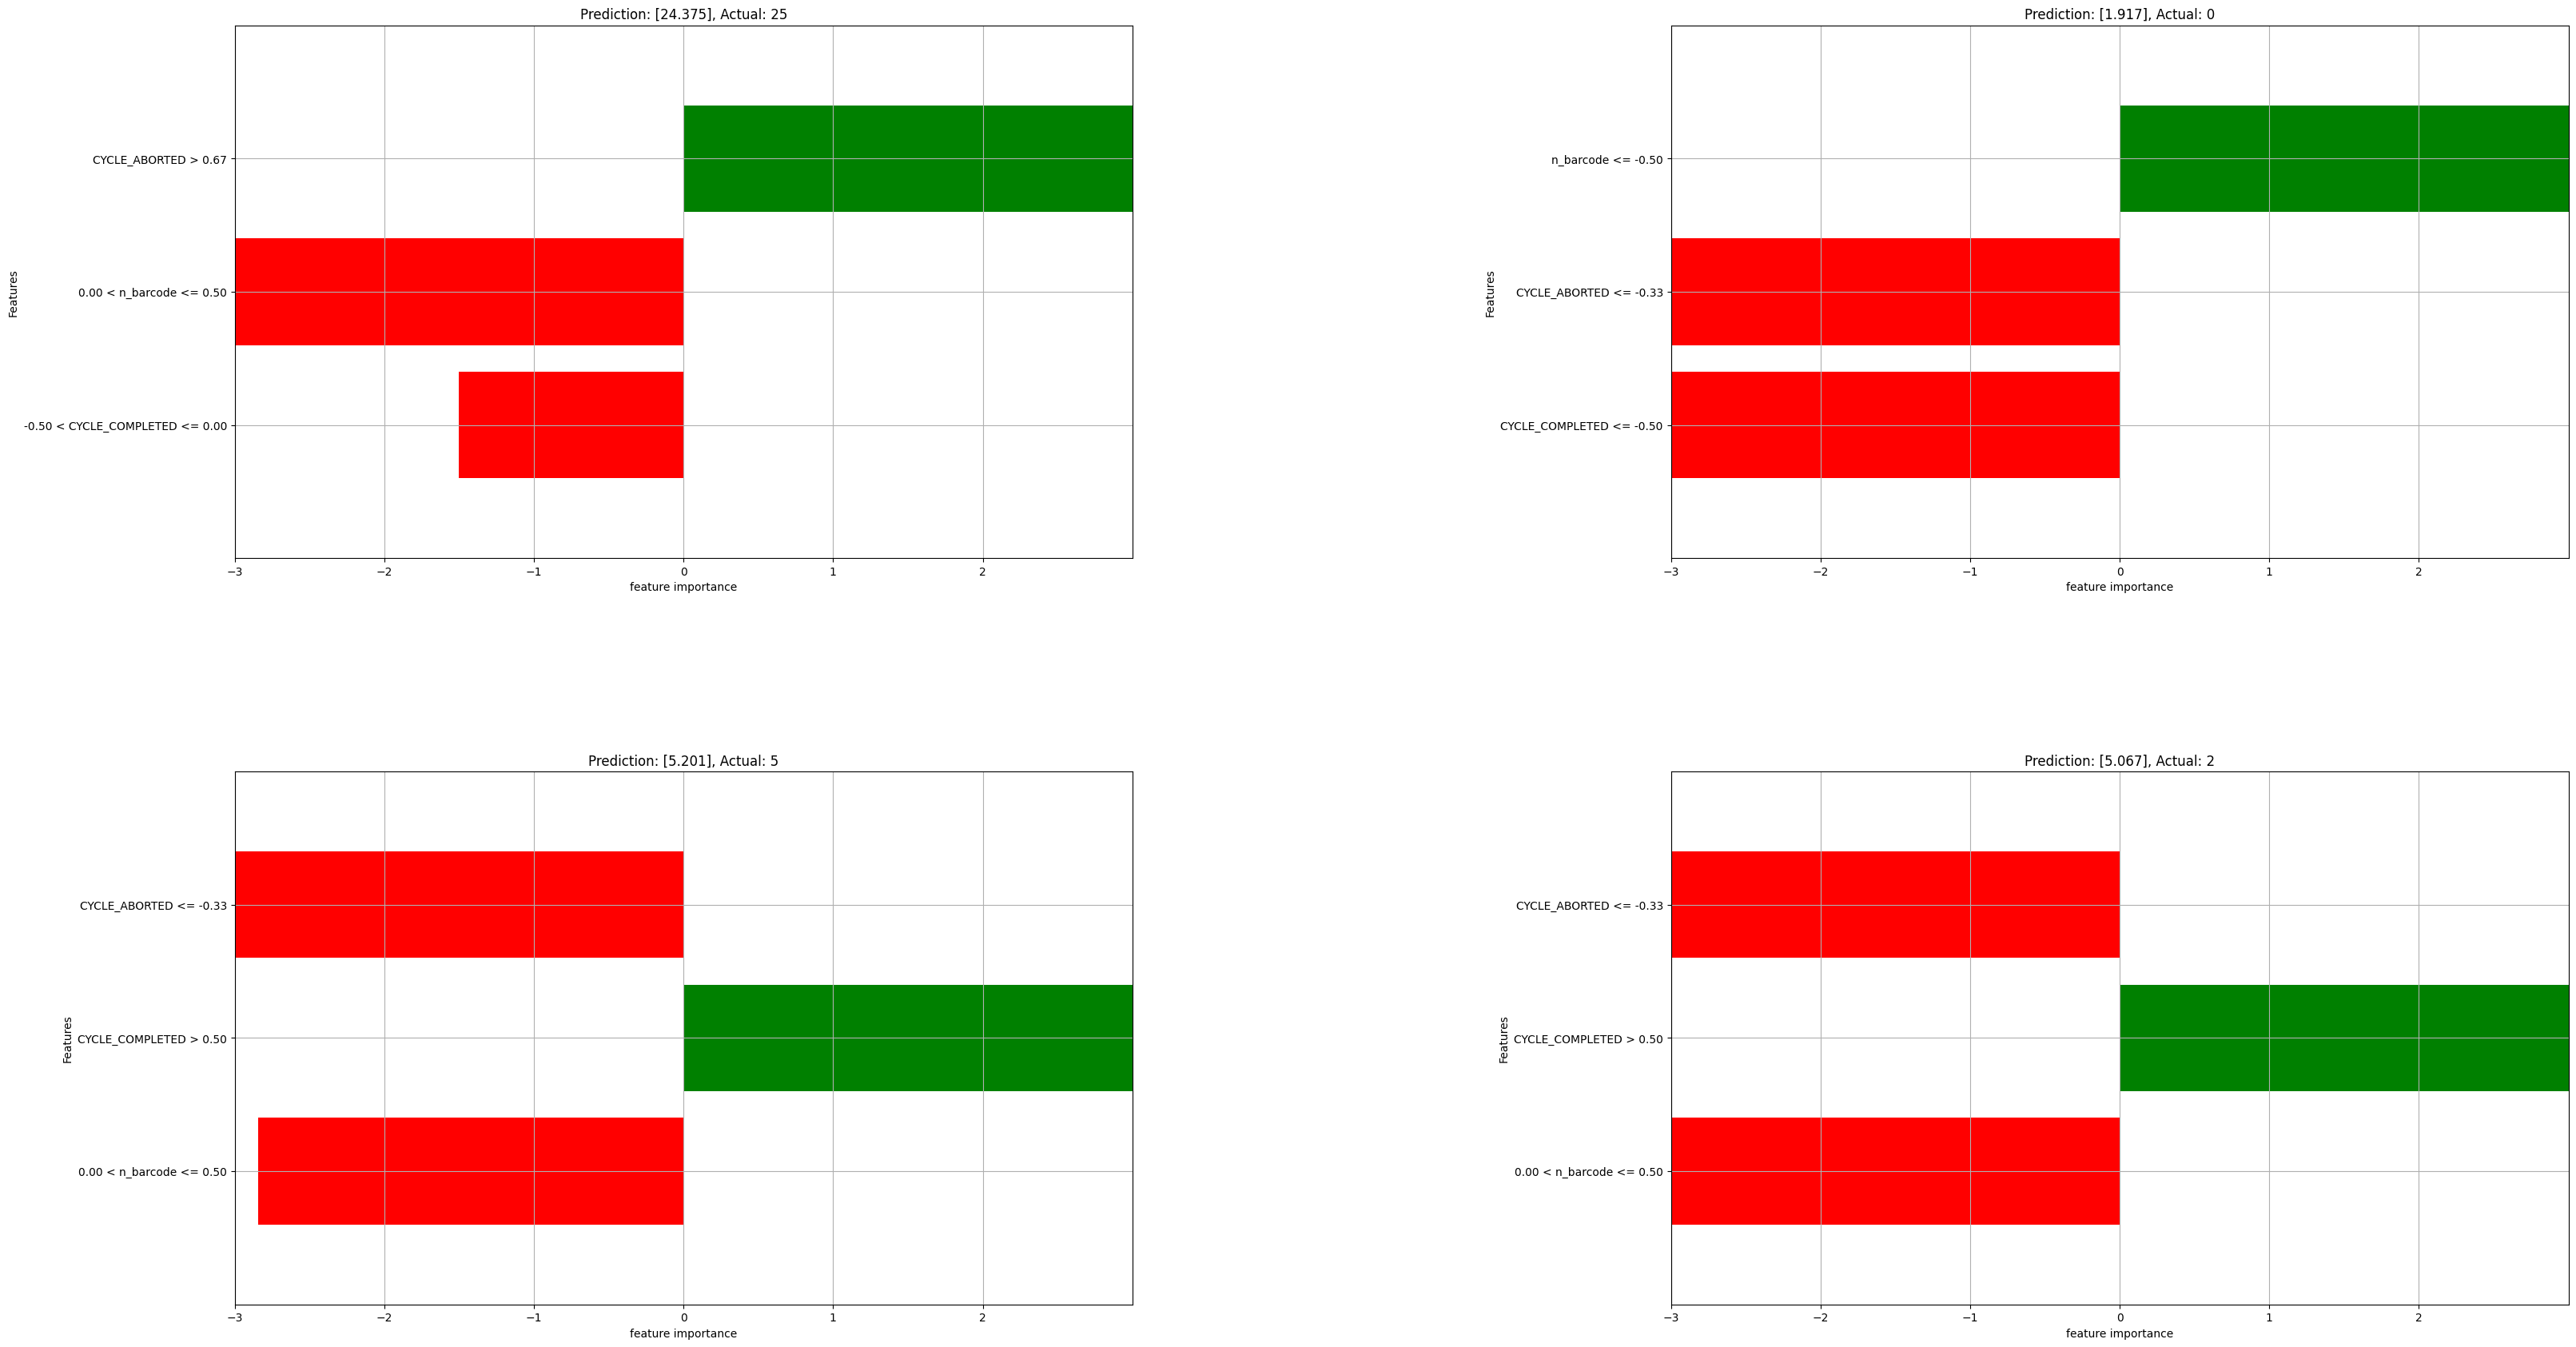

In [20]:
if __name__ == '__main__':
    model_eval = Model_Evaluator()
    dfs = []
    for i in range(80):
        df, current_machine = model_eval.get_data(i)
        dfs.append(df)
    df = pd.concat(dfs)
    df_tot, df_L, df_R = model_eval.split_tot_L_R_df(df)
    df_tot = model_eval.remove_outliers(df_tot)
    
    x, y , x_cols= model_eval.get_x_y(df_tot)
    x_ = decomposition.PCA(n_components=1).fit_transform(x)
    # plt.scatter(x_, y)
    # plt.show()
    
    
    
    # model = evaluations(x,y, log_regression, desc = "Logistic Regression")
    pca = decomposition.PCA(n_components=1)
    x_ = pca.fit_transform(x)
       
    scale_x, scale_y, scaler = model_eval.scale(x,y)
    
    model_svr, _ = model_eval.evaluations(scale_x,scale_y, svr_regression, desc = "SVR")
    model_lin, _ = model_eval.evaluations(scale_x,scale_y, lin_regr, desc = "Linear Regression")
    model_gb, _ = model_eval.evaluations(scale_x,scale_y, grad_boost, desc = "Gradient Boosting")
    model_stack, data_used = model_eval.evaluations(scale_x,scale_y, stack_regression, desc = "Stacking")
    model_adaboost, _ = model_eval.evaluations(scale_x,scale_y, adaboost_regression, desc = "AdaBoost")
    model_lasso, _ = model_eval.evaluations(scale_x,scale_y, lasso_regression, desc = "Lasso Regression")
    model_hist_gb, _ = model_eval.evaluations(scale_x,scale_y, hist_gb_regression, desc = "Hist Gradient Boosting")
    
    
    # model_gb_ = evaluations_on_new_data(scale_x,scale_y, grad_boost, desc = "Gradient Boosting")
    
    train = data_used[0]
    test = data_used[1]
    y_exp = data_used[3]
    
    x_test = data_used[1]
    y_test = data_used[3]
    
    x_test_pca = pca.transform(x_test)
    
    
    figure = plt.subplots(10,3)
    ax1 = plt.subplot(3,1,1)
    ax2 = plt.subplot(3,1,2)
    ax3 = plt.subplot(3,1,3)
    
    
    
    ax1.plot(y_test, label='Actual')
    
    ax1.plot(model_gb.predict(x_test), label='Gradient Boosting')
    ax1.legend()
    ax1.grid()
    ax1.set_xlim(0,200)
    ax2.plot(y_test, label='Actual')
    ax2.plot(model_hist_gb.predict(x_test), label='Hist Gradient Boosting')
    ax2.legend()
    ax2.grid()
    ax2.set_xlim(0,200)
    ax3.plot(y_test, label='Actual')
    ax3.plot(model_stack.predict(x_test), label='Stacking: HGB, Lasso, AdaBoost,\nGB, Lin, SVR')
    
    ax3.legend()
    ax3.grid()
    ax3.set_xlim(0,200)
    figure[0].set_size_inches(40,20)
    plt.xlabel(f'PCA Components: {x_cols}')
    plt.ylabel('Cumulative Aborted Cycles per day')
    
    plt.show()
    
    
    
    
    model_eval.explain_model(model_stack, train, test, x_cols, y_exp)
